In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [3]:
from copy import deepcopy
import pickle
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, value_and_grad, vmap
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

import jaxley as jx
from jaxley.channels import HH
from jaxley.optimize import TypeOptimizer

In [4]:
n_train = 32
n_test = 16
seed = 0
batch_size = 1
stims_in_layers = 1
switch_labels = 0
depth = 2
data_std = 0.1
nseg_per_branch = 4

dt = 0.025
t_max = 5.95
i_delay = 1.0
i_dur = 0.9
i_amp = 0.05

time_vec = np.arange(0, t_max+2*dt, dt)

### Helper functions

In [5]:
def gen_data(n_data=3_000, switch_labels: int = 0, std: float = 0.1, center_x: float = 2.0, center_y: float = 2.0, spacing: float = 1.0):
    """Generate training data."""

    num_blobs = 3

    x_locs = np.linspace(center_x - spacing, center_x + spacing, num_blobs)
    y_locs = np.linspace(center_y + spacing, center_y - spacing, num_blobs)
    
    blobs_pos = []
    blobs_neg = []
    class_label = []
    for blob in range(num_blobs):
        xs = np.random.randn(n_data) * std + x_locs[blob]
        ys = np.random.randn(n_data) * std + y_locs[blob]
        
        if not blob % 2:
            blobs_pos.append(np.stack([xs, ys]).T)
        else:
            blobs_neg.append(np.stack([xs, ys]).T)

    class0 = np.concatenate(blobs_pos)
    class1 = np.concatenate(blobs_neg)

    inds = np.random.permutation(np.arange(len(class0)))
    class0 = class0[inds][: n_data // 2]
    inds = np.random.permutation(np.arange(len(class1)))
    class1 = class1[inds][: n_data // 2]

    all_data = np.concatenate([class0, class1])
    if switch_labels:
        all_labels = np.concatenate([np.zeros(n_data // 2), np.ones(n_data // 2)])
    else:
        all_labels = np.concatenate([np.ones(n_data // 2), np.zeros(n_data // 2)])

    inds = np.random.permutation(np.arange(len(all_labels)))
    all_data = all_data[inds]
    all_labels = all_labels[inds]
    all_voltage_labels = deepcopy(all_labels)

    all_voltage_labels[all_voltage_labels == 0] = -70.0
    all_voltage_labels[all_voltage_labels == 1] = 35.0

    return all_data, all_labels, all_voltage_labels


In [6]:
parents = [-1] + [b // 2 for b in range(0, 2**depth - 2)]
parents = jnp.asarray(parents)

num_branches = len(parents)

comp = jx.Compartment().initialize()
branch = jx.Branch([comp for _ in range(nseg_per_branch)]).initialize()
cell = jx.Cell([branch for _ in range(num_branches)], parents=parents).initialize()

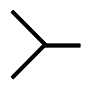

In [7]:
cell.compute_xyz()
cell.rotate(180)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.92, 0.92))
    ax = cell.vis(ax=ax, morph_plot_kwargs={"linewidth": 2.5})
    _ = ax.spines["left"].set_visible(False)
    _ = ax.spines["bottom"].set_visible(False)
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
    # plt.savefig("results/figs/fig1/svg/simple_morph.svg", dpi=200, bbox_inches="tight")

In [8]:
def build_cell():
    parents = [-1] + [b // 2 for b in range(0, 2**depth - 2)]
    parents = jnp.asarray(parents)
    
    num_branches = len(parents)
    
    comp = jx.Compartment().initialize()
    branch = jx.Branch([comp for _ in range(nseg_per_branch)]).initialize()
    cell = jx.Cell([branch for _ in range(num_branches)], parents=parents).initialize()
    
    cell.insert(HH())
    
    cell.set("v", -70.0)
    cell.set("HH_m", 0.074901)
    cell.set("HH_h", 0.4889)
    cell.set("HH_n", 0.3644787)
    
    cell.branch(0).loc(0.0).record()

    for key in lowers.keys():
        cell.branch("all").comp("all").make_trainable(
            key, np.random.rand() * (uppers[key] - lowers[key]) + lowers[key], verbose=False
        )
    return cell

In [9]:
def simulate(params, image):
    currents = jx.datapoint_to_step_currents(i_delay, i_dur, i_amp * image, dt, t_max)

    data_stimuli = None
    for i, current in zip(range(2 * num_repeats), currents):
        data_stimuli = cell.branch(stim_branches[i]).loc(stim_locs[i]).data_stimulate(current, data_stimuli=data_stimuli)

    s = jx.integrate(cell, params=params, data_stimuli=data_stimuli)
    return s

vmapped_sim = vmap(simulate, in_axes=(None, 0))
jitted_sim = jit(vmapped_sim)

def predict(params, image):
    s = simulate(params, image)
    return s[0, 120]

batched_predict = vmap(predict, in_axes=(None, 0))
jitted_batched_predict = jit(batched_predict)

def loss(params, images, labels):
    predictions = batched_predict(transform.forward(params), images)
    errors = jnp.abs(predictions - labels)
    return jnp.mean(errors)

loss_grad = jit(value_and_grad(loss, argnums=0))

In [10]:
def evaluate(params):
    all_traces = []
    all_labels = []
    for batch in dataset_test:
        image_batch, label_batch = tfds.as_numpy(batch)
        sim_outs = jitted_sim(params, image_batch)
        all_traces.append(sim_outs)
        all_labels.append(label_batch)
    return jnp.concatenate(all_traces), jnp.stack(all_labels)
    
def vis_traces(traces, time_vec, labels):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    for i, trace in enumerate(traces):
        col = "k" if labels[i] != -70.0 else "#d7301f"
        _ = ax.plot(time_vec, trace[0, :-1], c=col, linewidth=0.4, alpha=0.4)
        _ = ax.set_xlim([0, max(time_vec)])
        _ = ax.set_ylim([-80, 50])
        _ = ax.set_xlabel("Time (ms)")
        _ = ax.set_ylabel("Voltage (mV)")

In [11]:
def decision_surface(params, resolution=10):
    datax = np.linspace(0.0, 5.0, resolution)
    datay = np.linspace(0.0, 5.0, resolution)
    X, Y = np.meshgrid(datax, datay)
    stacked = np.stack([X, Y])
    xy = np.reshape(stacked, (2, resolution**2)).T
    xy = np.tile(xy, num_repeats)
    predictions_on_grid = jitted_batched_predict(params, xy)

    predictions = np.reshape(predictions_on_grid, (resolution, resolution))
    return predictions


def vis_decision_surface(predictions):
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 0.92))
    p = ax.imshow(
        predictions,
        origin="lower",
        extent=[0, 5, 0, 5],
        vmin=-80.0,
        vmax=50.0,
    )
    cb = plt.colorbar(p, ticks=[-80, 50])
    return ax, cb

### Define curriculums for curriculum learning

In [12]:
stim_branches = np.concatenate(
    [
        np.arange(2 ** (depth + v) - 1, 2 ** (depth + v + 1) - 1)
        for v in range(-stims_in_layers, 0)
    ]
)
num_repeats = len(stim_branches) // 2
stim_locs = 1.0 * np.ones(2 * num_repeats)

lowers = {
    "radius": 0.1,
    "length": 1.0,
    "axial_resistivity": 500.0,
    "HH_gNa": 0.05,
    "HH_gK": 0.01,
    "HH_gLeak": 0.0001,
}
uppers = {
    "radius": 5.0,
    "length": 20.0,
    "axial_resistivity": 5500.0,
    "HH_gNa": 1.1,
    "HH_gK": 0.3,
    "HH_gLeak": 0.001,
}
transform = jx.ParamTransform(
    lowers=lowers,
    uppers=uppers,
)

In [13]:
loss_grad = jit(value_and_grad(loss, argnums=0))

In [14]:
# Works from scratch
center_x1 = 2.5
center_y1 = 2.5
spacing1 = 1.0

center_x2 = 1.0
center_y2 = 3.1
spacing2 = 0.9

centers_x = [center_x1, center_x2]
centers_y = [center_y1, center_y2]
spacings = [spacing1, spacing2]

lr = 0.01

### Train

In [16]:
# start_time = time.time()
# loss_val, gradient = loss_grad(opt_params, image_batch, label_batch)
# print("time", (time.time() - start_time)*1000)

New cell
Added 1 recordings. See `.recordings` for details.


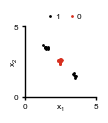

epoch_loss 1681.8035780230257
epoch_loss 1680.6335788885663
epoch_loss 810.2553706916248
epoch_loss 749.5674446439779
epoch_loss 11.850982852350313


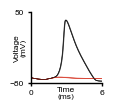

New cell
Added 1 recordings. See `.recordings` for details.


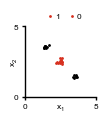

epoch_loss 1684.2974124128996
epoch_loss 1694.4661517838483
epoch_loss 1680.047697281582
epoch_loss 1683.4277102031842
epoch_loss 1681.6272209250205


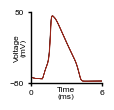

New cell
Added 1 recordings. See `.recordings` for details.


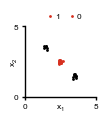

epoch_loss 1701.4373479468104
epoch_loss 8.691109570642347
epoch_loss 6.577127022224644
epoch_loss 7.3521460735582025
epoch_loss 9.338988577953295


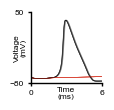

New cell
Added 1 recordings. See `.recordings` for details.


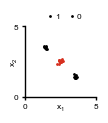

epoch_loss 1781.3932673716604
epoch_loss 1680.1502217388247
epoch_loss 1680.9908425840922
epoch_loss 1680.6119237715031
epoch_loss 848.1726283519776


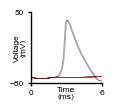

New cell
Added 1 recordings. See `.recordings` for details.


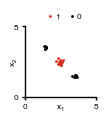

epoch_loss 1903.6179793354163
epoch_loss 1662.5004455258593
epoch_loss 1630.8605918268836
epoch_loss 1499.5432889281517
epoch_loss 1407.4701802315444


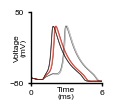

New cell
Added 1 recordings. See `.recordings` for details.


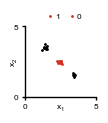

epoch_loss 1681.1034741965268
epoch_loss 1680.5360538745854
epoch_loss 1679.4670884427653
epoch_loss 681.4904894048669
epoch_loss 639.923886837097


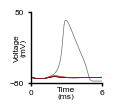

New cell
Added 1 recordings. See `.recordings` for details.


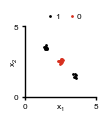

epoch_loss 1709.430530518773
epoch_loss 633.1501636145202
epoch_loss 77.15915640890793
epoch_loss 6.822238653191263
epoch_loss 4.761980002559191


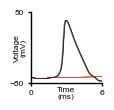

New cell
Added 1 recordings. See `.recordings` for details.


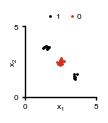

epoch_loss 1752.139073305369
epoch_loss 162.29787193953905
epoch_loss 67.46697259799171
epoch_loss 11.391125585060315
epoch_loss 10.519732160989435


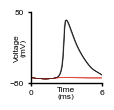

New cell
Added 1 recordings. See `.recordings` for details.


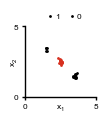

epoch_loss 1728.8341043509336
epoch_loss 1680.8566289337505
epoch_loss 1680.1073807240086
epoch_loss 1665.06480731099
epoch_loss 1674.7007814613057


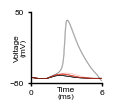

New cell
Added 1 recordings. See `.recordings` for details.


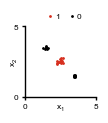

epoch_loss 1682.7776233895022
epoch_loss 1679.4727597018168
epoch_loss 1686.3719723433876
epoch_loss 1680.6067708203507
epoch_loss 1679.4473894923592


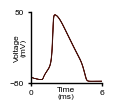

In [17]:
from copy import deepcopy

all_opt_params = []
counter = 0
all_gd_losses = []
for seed in range(10):
    for center_x, center_y, spacing in zip(centers_x[:1], centers_y[:1], spacings[:1]):
        print("New cell")
        tf.random.set_seed(42+seed)  # 39,40,41,42 works
        _ = np.random.seed(1+seed) # 0 works
    
        cell = build_cell()
        params = cell.get_parameters()
        opt_params = transform.inverse(params)
    
        train_images, train_labels, train_voltages = gen_data(
            n_train, switch_labels=switch_labels, std=data_std, center_x=center_x, center_y=center_y, spacing=spacing,
        )
        test_images, _, test_voltages = gen_data(
            n_test, switch_labels=switch_labels, std=data_std, center_x=center_x, center_y=center_y, spacing=spacing,
        )
    
        train_images = np.tile(train_images, num_repeats)
        test_images = np.tile(test_images, num_repeats)
    
        with mpl.rc_context(fname="../../../.matplotlibrc"):
            fig, ax = plt.subplots(1, 1, figsize=(0.92, 0.92))
            for p, l in zip(train_images[:100], train_labels[:100]):
                _ = ax.scatter(p[0], p[1], c="k" if l else "#d7301f", s=1.0)
            _ = ax.set_xlim([0, 5])
            _ = ax.set_ylim([0, 5])
            _ = ax.set_xticks([0, 5])
            _ = ax.set_yticks([0, 5])
            _ = ax.set_xlabel(r"$x_1$", labelpad=-5)
            _ = ax.set_ylabel(r"$x_2$", labelpad=-5)
            _ = ax.legend(["1", "0"], loc="upper right", bbox_to_anchor=[0.9, 1.3, 0.0, 0.0],
                          ncols=2, columnspacing=0.4, handletextpad=-0.4)
    
            # plt.savefig(f"results/figs/fig1/svg/learned_data_simple_{counter}.svg", bbox_inches="tight", transparent=True)
            plt.show()

        lrs = {"radius": lr, "length": lr, "axial_resistivity": lr, "HH_gNa": lr, "HH_gK": lr, "HH_gLeak": lr}
        optimizer = TypeOptimizer(lambda lr: optax.adam(lr), lrs, opt_params)
        opt_state = optimizer.init(opt_params)
    
        dataset = tf.data.Dataset.from_tensor_slices((train_images, train_voltages))
        dataset = dataset.shuffle(dataset.cardinality()).batch(batch_size)
    
        dataset_test = tf.data.Dataset.from_tensor_slices((test_images, test_voltages))
        dataset_test = dataset_test.shuffle(dataset.cardinality()).batch(batch_size)

        gd_losses = []
        for epoch in range(200):
            epoch_loss = 0

            for batch in dataset:
                start_time = time.time()
                image_batch, label_batch = tfds.as_numpy(batch)
    
                loss_val, gradient = loss_grad(opt_params, image_batch, label_batch)
                epoch_loss += loss_val
    
                updates, opt_state = optimizer.update(gradient, opt_state)
                opt_params = optax.apply_updates(opt_params, updates)
    
            gd_losses.append(epoch_loss)
            if epoch % 40 == 0:
                print("epoch_loss", epoch_loss)
    
        all_opt_params.append(opt_params)
        traces, labels = evaluate(transform.forward(opt_params))
        with mpl.rc_context(fname="../../../.matplotlibrc"):
            fig, ax = plt.subplots(1, 1, figsize=(0.92, 0.92))
            for i, trace in enumerate(traces[:, :, :]):
                col = "k" if labels[i] != -70.0 else "#d7301f"
                _ = ax.plot(time_vec, trace[0], c=col, linewidth=0.4, alpha=0.4)
                # _ = ax.set_xlim([0, max(time_vec)])
                _ = ax.set_ylim([-80, 50])
                _ = ax.set_yticks([-80, 50])
                _ = ax.set_xticks([0, 6])
                _ = ax.set_xlim([0, 6])
                _ = ax.set_xlabel("Time\n(ms)", labelpad=-6)
                _ = ax.set_ylabel("Voltage\n(mV)", labelpad=-12)
        
            # plt.savefig(f"results/figs/fig1/svg/traces_simple_spiking_{counter}.svg", bbox_inches="tight", transparent=True)
            plt.show()
        counter += 1

    all_gd_losses.append(deepcopy(gd_losses))

In [18]:
traces, labels = evaluate(transform.forward(all_opt_params[0]))
with open("../results/04_nonlinear/traces.pkl", "wb") as handle:
    pickle.dump(traces, handle)
with open("../results/04_nonlinear/labels.pkl", "wb") as handle:
    pickle.dump(labels, handle)
with open("../results/04_nonlinear/time_vec.pkl", "wb") as handle:
    pickle.dump(time_vec, handle)
with open("../results/04_nonlinear/gd_loss.pkl", "wb") as handle:
    pickle.dump(all_gd_losses, handle)
with open("../results/04_nonlinear/train_images.pkl", "wb") as handle:
    pickle.dump(train_images, handle)
with open("../results/04_nonlinear/train_labels.pkl", "wb") as handle:
    pickle.dump(train_labels, handle)

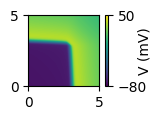

In [19]:
counter = 0
for opt_params in all_opt_params[:1]:
    prediction_grid = decision_surface(
        transform.forward(opt_params), resolution=80
    )
    with open("../results/04_nonlinear/gd_prediction_surface.pkl", "wb") as handle:
        pickle.dump(prediction_grid, handle)
    
    ax, cb = vis_decision_surface(predictions=prediction_grid)
    _ = ax.set_xticks([0, 5])
    _ = ax.set_yticks([0, 5])
    cb.set_label("V (mV)", labelpad=-7)
    
    # plt.savefig(f"results/figs/fig1/svg/learned_simple_surfaces_{counter}.svg", bbox_inches="tight", transparent=True)
    counter += 1

# Build a combined cell

In [20]:
num_subcells = 2
parents = [-1, 0, 1, 1, 0, 4, 4]
comp = jx.Compartment()
branch = jx.Branch(comp, nseg_per_branch)
cell = jx.Cell(branch, parents=parents)

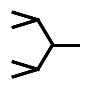

In [33]:
cell.compute_xyz()
cell.rotate(180)

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.92, 0.92))
    ax = cell.vis(ax=ax, morph_plot_kwargs={"linewidth": 2.0})
    _ = ax.spines["left"].set_visible(False)
    _ = ax.spines["bottom"].set_visible(False)
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
    # plt.savefig("results/figs/fig1/svg/morph.svg", bbox_inches="tight", transparent=True)

In [34]:
cell.insert(HH())
cell.set("v", -70.0)
cell.set("HH_m", 0.074901)
cell.set("HH_h", 0.4889)
cell.set("HH_n", 0.3644787)

In [35]:
branch_lists = [[0], [1, 2, 3], [4, 5, 6]]

for branch_list in branch_lists:
    cell.branch(branch_list).comp("all").make_trainable("radius")
    cell.branch(branch_list).comp("all").make_trainable("length")
    cell.branch(branch_list).comp("all").make_trainable("axial_resistivity")
    cell.branch(branch_list).comp("all").make_trainable("HH_gNa")
    cell.branch(branch_list).comp("all").make_trainable("HH_gK")
    cell.branch(branch_list).comp("all").make_trainable("HH_gLeak")

Number of newly added trainable parameters: 4. Total number of trainable parameters: 4
Number of newly added trainable parameters: 4. Total number of trainable parameters: 8
Number of newly added trainable parameters: 4. Total number of trainable parameters: 12
Number of newly added trainable parameters: 4. Total number of trainable parameters: 16
Number of newly added trainable parameters: 4. Total number of trainable parameters: 20
Number of newly added trainable parameters: 4. Total number of trainable parameters: 24
Number of newly added trainable parameters: 12. Total number of trainable parameters: 36
Number of newly added trainable parameters: 12. Total number of trainable parameters: 48
Number of newly added trainable parameters: 12. Total number of trainable parameters: 60
Number of newly added trainable parameters: 12. Total number of trainable parameters: 72
Number of newly added trainable parameters: 12. Total number of trainable parameters: 84
Number of newly added trainab

In [36]:
params = cell.get_parameters()

In [37]:
opt_params = transform.inverse(params[:6]) + all_opt_params[0] + all_opt_params[1]

In [39]:
cell.branch(1).loc(0.0).record()
cell.branch(4).loc(0.0).record()
cell.branch(0).loc(0.0).record()

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


In [24]:
def simulate(params, image):
    currents = jx.datapoint_to_step_currents(i_delay, i_dur, i_amp * image, dt, t_max)
    data_stimuli = None
    
    stim_branches = [2, 3]
    for stim_branch, current in zip(stim_branches, currents):
        data_stimuli = cell.branch(stim_branch).comp(1.0).data_stimulate(current, data_stimuli=data_stimuli)

    stim_branches = [5, 6]
    for stim_branch, current in zip(stim_branches, currents):
        data_stimuli = cell.branch(stim_branch).comp(1.0).data_stimulate(current, data_stimuli=data_stimuli)

    s = jx.integrate(cell, params=params, data_stimuli=data_stimuli)
    return s


vmapped_sim = vmap(simulate, in_axes=(None, 0))
jitted_sim = jit(vmapped_sim)


def predict(params, image):
    s = simulate(params, image)
    return s[:, 120]


batched_predict = vmap(predict, in_axes=(None, 0))
jitted_batched_predict = jit(batched_predict)


def decision_surface(params, resolution=10):
    datax = np.linspace(0.0, 4.0, resolution)
    datay = np.linspace(0.0, 4.0, resolution)
    X, Y = np.meshgrid(datax, datay)
    stacked = np.stack([X, Y])
    xy = np.reshape(stacked, (2, resolution**2)).T
    xy = np.tile(xy, num_repeats)
    predictions_on_grid = jitted_batched_predict(params, xy)
    all_predictions = []
    for i in range(3):
        predictions = np.reshape(predictions_on_grid[:, i], (resolution, resolution))
        all_predictions.append(predictions)
    return all_predictions

In [25]:
center_x1 = 3.2
center_y1 = 1.9
spacing1 = 0.5

center_x2 = 1.0
center_y2 = 3.1
spacing2 = 0.5

In [26]:
all_train_images = []
all_train_voltages = []
all_test_images = []
all_test_voltages = []

for center_x, center_y in zip([center_x1, center_x2], [center_y1, center_y2]):
    spacing = 0.5
    
    train_images, train_labels, train_voltages = gen_data(
        n_train, switch_labels=switch_labels, std=data_std, center_x=center_x, center_y=center_y, spacing=spacing,
    )
    test_images, _, test_voltages = gen_data(
        n_test, switch_labels=switch_labels, std=data_std, center_x=center_x, center_y=center_y, spacing=spacing,
    )
    
    train_images = np.tile(train_images, num_repeats)
    test_images = np.tile(test_images, num_repeats)

    all_train_images.append(train_images)
    all_train_voltages.append(train_voltages)
    all_test_images.append(test_images)
    all_test_voltages.append(test_voltages)

all_train_images = np.concatenate(all_train_images, axis=0)
all_train_voltages = np.concatenate(all_train_voltages, axis=0)
all_test_images = np.concatenate(all_test_images, axis=0)
all_test_voltages = np.concatenate(all_test_voltages, axis=0)

all_train_voltages[all_train_voltages == 35.0] = 35.0  # 35
all_train_voltages[all_train_voltages == -70.0] = -65.0  # -60.0

all_test_voltages[all_test_voltages == 35.0] = 35.0  # 35
all_test_voltages[all_test_voltages == -70.0] = -65.0  # -60.0

In [27]:
prediction_grid = decision_surface(
    transform.forward(opt_params), resolution=80
)

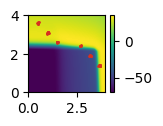

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(1.25, 1))
p = ax.imshow(
    prediction_grid[0],
    origin="lower",
    extent=[0.0, 4.0, 0.0, 4.0],
    vmin=-70.0,
    vmax=35.0,
)
plt.colorbar(p)
for p, l in zip(all_train_images[1:100], all_train_voltages[1:100]):
    _ = ax.scatter(p[0], p[1], c="k" if l==-60.0 else "#d7301f", s=1.0)

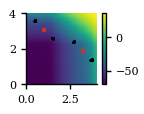

In [29]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 0.92))
    p = ax.imshow(
        prediction_grid[2],
        origin="lower",
        extent=[0.0, 4.0, 0.0, 4.0],
        vmin=-70.0,
        vmax=35.0,
    )
    plt.colorbar(p)
    for p, l in zip(all_train_images[1:100], all_train_voltages[1:100]):
        _ = ax.scatter(p[0], p[1], c="k" if l==35.0 else "#d7301f", s=1.0)
    
    plt.savefig("results/figs/fig1/svg/initial_complex_surface.svg", bbox_inches="tight", transparent=True)

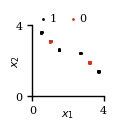

In [30]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.92, 0.92))
    for p, l in zip(all_train_images[3:100], all_train_voltages[3:100]):
        _ = ax.scatter(p[0], p[1], c="k" if l==35.0 else "#d7301f", s=1.0)
    _ = ax.set_xlim([0, 4])
    _ = ax.set_ylim([0, 4])
    _ = ax.set_xticks([0, 4])
    _ = ax.set_yticks([0, 4])
    _ = ax.set_xlabel(r"$x_1$", labelpad=-5)
    _ = ax.set_ylabel(r"$x_2$", labelpad=-5)
    _ = ax.legend(["1", "0"], loc="upper right", bbox_to_anchor=[0.9, 1.3, 0.0, 0.0],
                  ncols=2, columnspacing=0.4, handletextpad=-0.4)

    plt.savefig("results/figs/fig1/svg/complex_data.svg", bbox_inches="tight", transparent=True)

In [31]:
def loss(params, images, labels):
    predictions = batched_predict(transform.forward(params), images)[:, -1]
    errors = jnp.abs(predictions - labels)
    return jnp.mean(errors)

loss_grad = jit(value_and_grad(loss, argnums=0))

In [32]:
_ = np.random.seed(1)
tf.random.set_seed(42)

In [33]:
val = 0.005
lrs = {"radius": val, "length": val, "axial_resistivity": val, "HH_gNa": val, "HH_gK": val, "HH_gLeak": val}

optimizer = TypeOptimizer(optax.adam, lrs, opt_params)
opt_state = optimizer.init(opt_params)

start_time = time.time()
loss_val, gradient = loss_grad(
    opt_params, all_train_images[: batch_size], all_train_voltages[: batch_size]
)
print("time", time.time() - start_time)

time 6.215394020080566


In [34]:
dataset = tf.data.Dataset.from_tensor_slices((all_train_images, all_train_voltages))
dataset = dataset.shuffle(dataset.cardinality()).batch(batch_size)

dataset_test = tf.data.Dataset.from_tensor_slices((all_test_images, all_test_voltages))
dataset_test = dataset_test.shuffle(dataset.cardinality()).batch(batch_size)

In [35]:
# epoch_losses = []
# all_params = []

# for epoch in range(800):
#     epoch_loss = 0

#     for batch in dataset:
#         start_time = time.time()
#         image_batch, label_batch = tfds.as_numpy(batch)

#         loss_val, gradient = loss_grad(opt_params, image_batch, label_batch)
#         epoch_loss += loss_val
        
#         updates, opt_state = optimizer.update(gradient, opt_state)
#         opt_params = optax.apply_updates(opt_params, updates)

#     epoch_losses.append(epoch_loss)
#     all_params.append(transform.forward(opt_params))

#     if epoch % 20 == 0:
#         print("epoch_loss", epoch_loss)

# import pickle
# with open("results/parameters/opt_params_complex.pickle", "wb") as handle:
#     pickle.dump(opt_params, handle)

In [36]:
with open("results/parameters/opt_params_complex.pickle", "rb") as handle:
    opt_params = pickle.load(handle)

In [37]:
prediction_grid = decision_surface(
    transform.forward(opt_params), resolution=80
)

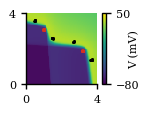

In [38]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 0.92))
    p = ax.imshow(
        prediction_grid[2],
        origin="lower",
        extent=[0.0, 4.0, 0.0, 4.0],
        vmin=-80.0,
        vmax=50.0,
    )
    cb = plt.colorbar(p, ticks=[-80, 50])
    _ = ax.set_xticks([0, 4])
    _ = ax.set_yticks([0, 4])
    cb.set_label("V (mV)", labelpad=-7)
    for p, l in zip(all_train_images[1:100], all_train_voltages[1:100]):
        _ = ax.scatter(p[0], p[1], c="k" if l==35.0 else "#d7301f", s=1.0)
    
    plt.savefig("results/figs/fig1/svg/complex_decision_surface_continuous.svg", bbox_inches="tight", transparent=True)

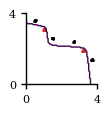

In [39]:
binary_grid = np.asarray(prediction_grid[2] > -36.0).astype(float)

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.92, 0.92))
    ax.contour(binary_grid, extent=[0.0, 4.0, 0.0, 4.0], levels=[0.5])
    for p, l in zip(all_train_images[1:100], all_train_voltages[1:100]):
        _ = ax.scatter(p[0], p[1], c="k" if l==35.0 else "#d7301f", s=1.0)
    
    ax.set_xticks([0, 4])
    ax.set_yticks([0, 4])
    plt.savefig("results/figs/fig1/svg/complex_decision_surface.svg", bbox_inches="tight", transparent=True)

In [40]:
traces, labels = evaluate(transform.forward(opt_params))

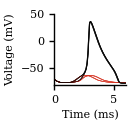

In [41]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.92, 0.92))
    for i, trace in enumerate(traces[:, 2:, :]):
        col = "k" if labels[i] != -65.0 else "#d7301f"
        _ = ax.plot(time_vec, trace[0], c=col, linewidth=0.4, alpha=0.4)
        _ = ax.set_xlim([0, max(time_vec)])
        _ = ax.set_ylim([-80, 50])
        _ = ax.set_xlabel("Time (ms)")
        _ = ax.set_ylabel("Voltage (mV)")

    plt.savefig("results/figs/fig1/svg/traces_nonlinear_spiking.svg", bbox_inches="tight", transparent=True)

In [27]:
import time
import IPython.display as IPd
from svgutils.compose import *

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

svg_scale = 1.25
# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}

f = Figure("15.5cm", "3.6cm",

    Panel(
          SVG("results/figs/fig1/svg/learned_data_simple_0.svg").scale(svg_scale),
        # Text("b", -5, 2.0, **kwargs_text),
    ).move(00, 00),

    # Panel(
    #       SVG("results/figs/fig1/svg/learned_data_simple_1.svg").scale(svg_scale),
    # ).move(100, 20),

    Panel(
          SVG("results/figs/fig1/svg/simple_morph.svg").scale(svg_scale),
    ).move(180, 20),

    Panel(
          SVG("results/figs/fig1/svg/traces_simple_spiking_0.svg").scale(svg_scale),
    ).move(260, 11.5),

    # Panel(
    #       SVG("results/figs/fig1/svg/traces_simple_spiking_1.svg").scale(svg_scale),
    # ).move(400, 20),

    Panel(
          SVG("results/figs/fig1/svg/learned_simple_surfaces_0.svg").scale(svg_scale),
    ).move(370, 11.0),

    # Panel(
    #       SVG("results/figs/fig1/svg/learned_simple_surfaces_1.svg").scale(svg_scale),
    # ).move(600, 20),
)

!mkdir -p fig
f.save("results/figs/fig1/figA.svg")
svg("results/figs/fig1/figA.svg")

In [28]:
import time
import IPython.display as IPd
from svgutils.compose import *

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

svg_scale = 1.25
# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}

f = Figure("6.3cm", "3.4cm",

    # Panel(
    #       SVG("results/figs/fig1/svg/complex_data.svg").scale(svg_scale),
    # ).move(0, 0),

    Panel(
          SVG("results/figs/fig1/svg/morph.svg").scale(svg_scale),
    ).move(0, 15),

    # Panel(
    #       SVG("results/figs/fig1/svg/traces_nonlinear_spiking.svg").scale(svg_scale),
    # ).move(300, 20),
    
    Panel(
          SVG("results/figs/fig1/svg/complex_decision_surface_continuous.svg").scale(svg_scale),
    ).move(80, 10),
)

!mkdir -p fig
f.save("results/figs/fig1/figB.svg")
svg("results/figs/fig1/figB.svg")